In [ ]:
# General comments and considerations

In [2]:
# General stuff
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os,re
import time
import nibabel as nib
from subprocess import Popen, PIPE
from os.path import join as opj
import math
from IPython.core.debugger import Tracer
from nilearn.decomposition import CanICA,DictLearning

# sklearn stuff
from sklearn.decomposition import TruncatedSVD,FastICA
from sklearn.preprocessing import scale
import sklearn.metrics.cluster as metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster.hierarchical import _hc_cut # Internal function to cut ward tree, helps speed up things a lot
from sklearn.utils import resample
from sklearn.model_selection import KFold

# personal functions
from importlib import reload
import myutils as mu
reload(mu)

if os.path.exists('/data1/vbeliveau/'):
    # On NRU server
    cluster_code='/data1/vbeliveau/5HT_clustering'
    cluster_data='/data1/vbeliveau/5HT_clustering_data'
    subjects_dir='/usr/local/nru/freesurfer/subjects'
elif os.path.exists('C:/Users/vbeliveau/'):
    # On laptop
    cluster_code='C:/Users/vbeliveau/Documents/GitHub/5HT_clustering'
    cluster_data='C:/Users/vbeliveau/Documents/5HT_clustering_data'
    subjects_dir='C:/Users/vbeliveau/Downloads/'
else:
    raise ValueError('Unknown location')
    
# Analysis directories
surf_data=opj(cluster_data,'surf_data')
mu.assert_dir(surf_data)
BPnd_data=opj(cluster_data,'BPnd')
mu.assert_dir(BPnd_data)
MFA_data=opj(cluster_data,'MFA')
MFA_preproc=opj(MFA_data,'preproc')
mu.assert_dir(MFA_data)
mu.assert_dir(MFA_preproc)

info_path=opj(cluster_code,'info_alltracers_base_healthy_hrrt.mat')
hemi_type=['lh','rh']

info=sio.loadmat(info_path)
tracers=['cumi','dasb','sb','az','C36']
petID=[item for subl in info['petID'] for subsubl in subl for item in subsubl]

In [5]:
# Sync data directories
# nrudata.nru.dk/data1 has been mapped to Z:
from dirsync import sync
a=sync('Z:/vbeliveau/5HT_clustering_data',cluster_data,'sync',verbose=True,create=True)

In [69]:
# ICA, CanICA and DictLearning on concatenated mean BPnd

tracers=['cumi','dasb','sb','az','C36']
hemi_type=['lh','rh']
targ='fsaverage5'
sm='10'
K_range=np.arange(3,len(tracers)+1)

# Extract data
img=np.ndarray(len(tracers),dtype=object)
data=np.empty(len(tracers),dtype=object)
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    for hemi in hemi_type:
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mean.mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        if data[nt] is None:
            data[nt],_=mu.fs_load_surf_data(fname,mask=fmask)
        else:
            img,_=mu.fs_load_surf_data(fname,mask=fmask)
            data[nt]=np.concatenate((data[nt],img),axis=0)
data=scale(np.column_stack(data),axis=0)

ica=FastICA()
canica=CanICA()
dict_learning = DictLearning()
estimators=[canica]
for estimator in estimators:
    print(estimator.__class__.__name__)
    dest=opj(BPnd_data,estimator.__class__.__name__)
    mu.assert_dir(dest)
    for nk,ni in zip(K_range,np.arange(0,len(K_range))+1):
        print(str(ni)+','+str(nk))
        estimator.set_params(n_components=nk)
        if isinstance(estimator,FastICA):            
#             S=estimator.fit_transform(np.transpose(data))
#             A=estimator.mixing_
            A=ica.fit_transform(np.transpose(data))
            S=ica.mixing_    
        elif isinstance(estimator,(CanICA,DictLearning)):
#             nib_data=[nib.Nifti1Image(np.reshape(data[:,nc],[1,data.shape[0],1]),
#                 np.eye(4)) for nc in np.arange(0,data.shape[1])]
            nib_data=[nib.Nifti1Image(np.reshape(data[nr],[1,data.shape[1],1]),
                np.eye(4)) for nr in np.arange(0,data.shape[0])]
            mask=nib.Nifti1Image(np.ones([1,nib_data[0].shape[1],1]), np.eye(4))
            estimator.set_params(mask=mask,smoothing_fwhm=None,detrend=False,standardize=False,verbose=True)
            estimator.fit(nib_data)
            A=np.vstack(estimator.transform(nib_data))
#             S=np.transpose(estimator.components_)
    
        fout=[opj(dest,'k'+str(nk)+'.mean.bpnd.'+targ+'.'+hemi+'.sm'+sm+'.nii.gz') for hemi in hemi_type]
        fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
        mu.fs_save_surf_data(S,fout,mask=fmask)
        
        plt.title('K='+str(nk))
        plt.subplot(1,len(K_range),ni)
        plt.imshow(A)
    
    plt.show()


KeyboardInterrupt: 

In [43]:
from scipy import signal
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations
X=data

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
print(X.shape)
print(S_.shape)
print(A_.shape)

In [67]:
A.shape

(18715, 5)

In [ ]:
# Create surface maps of MFA weights and plot eigenvalue for a range of smoothness levels

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
smooth=['0','5','10']
hemi_type=['lh','rh']

Kmax=10 # Maximum number of components to consider
svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')

plot_eigs=False
save_maps=True
dest=opj(MFA_data,'weights')
mu.assert_dir(dest)

for tracer in tracers:
    if plot_eigs:
        plt.figure(figsize=(10,2))
    for sm,nplt in zip(smooth,np(1,len(smooth)+1)):
        # Load the data
        preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
        data=preproc['arr_0']
        eig1=preproc['arr_1']
        N=len(data)

        # Divide all datasets by first eigenval
        for ns in np.arange(0,N):
            data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities

        # Perform SVD
        svd.fit(np.transpose(np.hstack(data)))
        U=np.transpose(svd.components_)
        S=np.linalg.svd(np.hstack(data),full_matrices=False,compute_uv=False)
        if plot_eigs:
            plt.subplot(1,len(smooth),nplt)
            plt.plot(np.arange(1,Kmax+1),S[0:Kmax])
            plt.title(tracer + ', sm' + sm)
            
        if save_maps: # Save weights out as surface overlay
            fname=[opj(dest,tracer + '.' + targ +'.' +hemi+ '.sm' + sm + '.nii.gz') 
                   for hemi in hemi_type]
            fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
            mu.fs_save_surf_data(U,fname,mask=fmask,verbose=True)
    if plot_eigs:
        plt.show()

In [80]:
# Perform MFA on the combined data from all tracers

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
sm='5'
hemi_type=['lh']

do_MFA=False
K_max=10 # Maximum number of components to consider
svd=TruncatedSVD(n_components=K_max,algorithm='arpack')

do_ward=True
do_whole=True
do_split=True
K_range=np.arange(10,300)

# Gather data
data=None
group=None
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    preproc_data=preproc['arr_0']
    eig1=preproc['arr_1']
    N=len(preproc_data)

    # Divide all datasets by first eigenval and number of subjects
    for ns in np.arange(0,N):
        preproc_data[ns]=preproc_data[ns]/(N*eig1[ns])
    
    if data is None:
        data=preproc_data
        data.dtype=object
        group=np.ones(N)*nt
    else:
        data=np.append(data,preproc_data)
        group=np.append(group,np.ones(N)*nt)

if do_MFA:
    # Compute MFA
    svd.fit(np.transpose(np.hstack(data)))
    U=np.transpose(svd.components_)
    S=np.linalg.svd(np.hstack(data),full_matrices=False,compute_uv=False)

    # Plot eigenvalues
    rng=np.arange(0,K_max)
    plt.plot(rng+1,S[rng])
    plt.show()

    # Save maps out
    dest=opj(MFA_data,'maps')
    mu.assert_dir(dest)
    fname=[opj(dest,'all.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz') for hemi in hemi_type]
    fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
    mu.fs_save_surf_data(U,fname,mask=fmask,verbose=True)

if do_ward:
    dest=opj(MFA_data,'ward')
    mu.assert_dir(dest)
    nstart=0
    nstop=0
    for hemi in hemi_type:
        adjacency,_=mu.fs_load_surf_neighborhood(opj(surf_data,'neigh.'+targ+'.'+hemi+'.matrix'))
        nstop=nstop+adjacency.shape[0]
        hemi_data=np.ndarray(len(data),dtype='object')
        for ns in np.arange(0,len(data)):
            hemi_data[ns]=data[ns][nstart:nstop,:]
        if do_whole:        
            fname=opj(dest,'all.'+targ+'.'+hemi+'.nii.gz')
            fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
            mu.ward_clustering(hemi_data,adjacency,mode='whole',K_range=K_range,save_out=fname,
                            mask=fmask,svd=True,K_svd=2,verbose=True)
        if do_split:
            mu.ward_clustering(hemi_data,adjacency,mode='split',K_range=K_range,N_iter=1,
                               svd=True,K_svd=2,verbose=True,group=group)    
    

Performing ward clustering of the whole dataset


KeyboardInterrupt: 

In [3]:
# Plot BPnd and MFA maps side by side
%gui qt

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
sm='10'
hemi='lh'
fsurf=opj(subjects_dir,targ,'surf',hemi+'.pial')

for tracer in tracers:
    fname=opj(BPnd_data,'maps',tracer,'mean.mrtm2.nopvc.'+targ+'.'+hemi+'.sm'+sm+'.nii.gz')
    data=mu.fs_load_surf_data(fname)
    img=mu.fs_surf_view(fsurf,data=data,view=['mid','side'],hemi=hemi,snap=True)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/vbeliveau/Documents/5HT_clustering_data\\BPnd\\maps\\cumi\\mean.mrtm2.nopvc.fsaverage5.lh.sm10.nii.gz'

In [ ]:
# Perform bootstrap of the MFA components to obtain an estimate of each component at the vertice level
# The goal here is to identify components containing significant "structures", and keep those components

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
targ='fsaverage5'
sm='5'

Niter=500 # Number of iterations (usually ~1000 or 10000)
Nupdate=50 # Number of iteration for verbose update
Kmax=10 # Maximum number of components to consider

conf=0.025

for tracer in tracers:
    
    # Load the data
    preproc=np.load(opj(MFA_data,tracer,'preproc.' + targ + '.sm' + sm + '.npz'))
    data=preproc['arr_0']
    eig1=preproc['arr_1']
    N=data.shape[0]
    Nvert=data[0].shape[0]
    
    # Divide all datasets by first eigenval
    for ns in np.arange(0,N):
        data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities
        
    svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')
    svd.fit(np.transpose(np.hstack(data)))
    U=np.transpose(svd.components_)
    S=np.linalg.svd(np.hstack(data), full_matrices=False, compute_uv=False)
    
    Zboot=np.ndarray([Nvert,Niter,Kmax])
    Sboot=np.ndarray([Kmax,Niter])
    start_t = time.time()
    if (Nupdate>0):
        print('Processing ' + tracer)
    for ni in np.arange(0,Niter): # Will need to parallelize this

        if (Nupdate>0 and ni % Nupdate == 0):
            print('Iter ' + str(ni))    
        
        # Get indices for current fold
        ind=resample(np.arange(0,N),replace=True)
        
        # Perform SVD and compute
        svd.fit(np.transpose(np.hstack(data[ind])))
        src_ind,_,Uboot=balance_svd_components(U,np.transpose(svd.components_),return_balanced=True)
        Zboot[:,ni,:]=scale(Uboot)
        Sboot[:,ni]=np.linalg.svd(np.hstack(data[ind]), full_matrices=False, compute_uv=False)[src_ind]
            
    # Build 95% confidence interval and find if 0 is within the interval at each vertice
    sig=np.empty([Nvert,Kmax])
    for nk in np.arange(0,Kmax):
        Zboot[:,:,nk]=np.sort(Zboot[:,:,nk],axis=1)
        ind=Zboot[:,Niter-1,nk]>0
        nind=np.logical_not(ind)
        sig[ind,nk]=Zboot[ind,int(np.round(Zboot.shape[1]*conf)),nk]>0 # 0 is not in the lower tail
        sig[nind,nk]=Zboot[nind,int(np.round(Zboot.shape[1]*conf)),nk]<0 # 0 is not in the upper tail
                    
    # Save components and eigval
    np.savez(opj(MFA_data,tracer,'bootstrap.data.' +  targ +'.sm' + sm),Zboot,Sboot,sig)
    
    # Save out mean Z maps and significant vertices as surface overlays
    fmask=[opj(surf_data,targ,hemi) for hemi in hemi_type]
    fname=opj(MFA_data,tracer,'bootstrap.Zmean.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz')
    mu.fs_save_surf_data( Zboot.mean(axis=1),fname,mask=fmask,verbose=True)
    fname=opj(MFA_data,tracer,'bootstrap.sig.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz')
    mu.fs_save_surf_data(sig,fname,mask=fmask,verbose=True)

Processing cumi


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


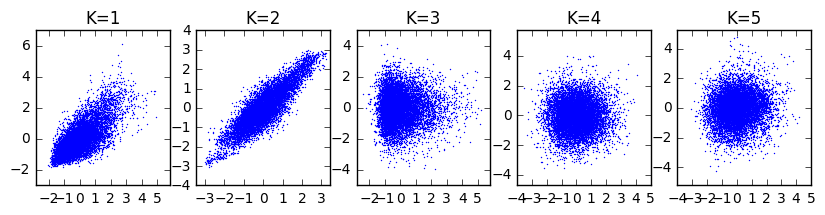

Processing dasb


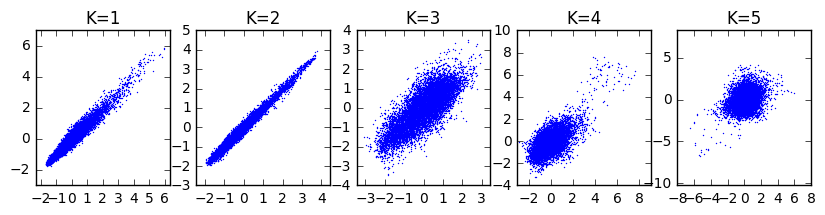

Processing sb


Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4018)
KeyboardInterrupt


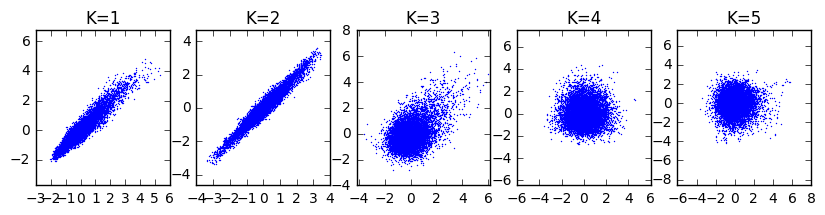

Processing az


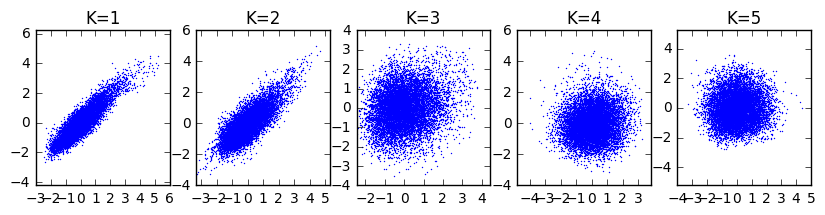

Processing C36


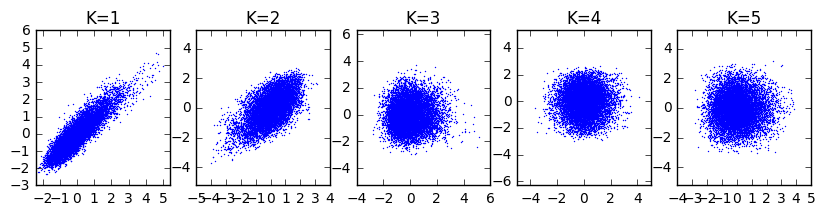

In [24]:
# Perform split-half evaluation the reproducibility of the MFA components

tracers=['cumi','dasb','sb','az','C36']
# tracers=['dasb']
targ='fsaverage5'
sm='5'

Niter=1 # Number of split-half iterations (usually ~1000 or 10000)
Kmax=5 # Maximum number of components to consider

plot_example=True
Nupdate=100

kf=KFold(n_splits=2,shuffle=True) # Split-half model
cc={}
cc_null={}
for tracer in tracers:
    
    # Load the data
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=preproc['arr_0']
    eig1=preproc['arr_1']
    N=data.shape[0]
    
    # Divide all datasets by first eigenval
    for ns in np.arange(0,N):
        data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities
        
    svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')    
    start_t = time.time()
    print('Processing ' + tracer)
    for ni in np.arange(0,Niter): # Will need to parallelize this

#         if (Nupdate>0 and ni % 100 == 0):
#             print('Iter ' + str(ni)            
        
        # Get indices for current fold
        split1,split2=kf.split(np.arange(0,N))
        
        # Perform SVD on split 1 & 2, separately
        svd.fit(np.transpose(np.hstack(data[split1[0]])))
        U1=scale(np.transpose(svd.components_))
        svd.fit(np.transpose(np.hstack(data[split2[0]])))
        U2=scale(np.transpose(svd.components_))
        [_,_,U2]=mu.balance_svd_components(U1,U2,return_balanced=True)
        
        plt.figure(figsize=(10,2))
        if plot_example:
            for nk in np.arange(0,Kmax):
                plt.subplot(1,Kmax,nk+1)
                plt.scatter(U1[:,nk],U2[:,nk],s=1,lw=0)
                plt.axis('equal')
                plt.title('K=' + str(nk+1))

            plt.show()

/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/BPnd/ward/cumi.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


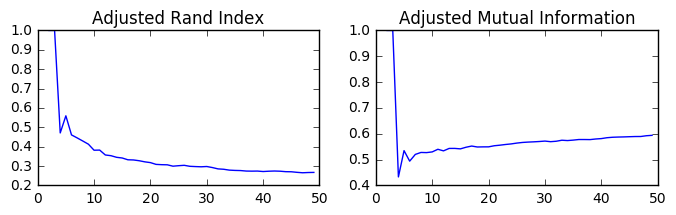

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/BPnd/ward/dasb.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


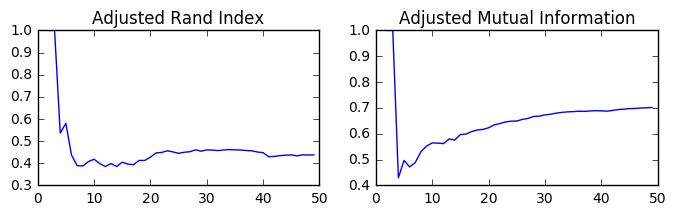

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/BPnd/ward/sb.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


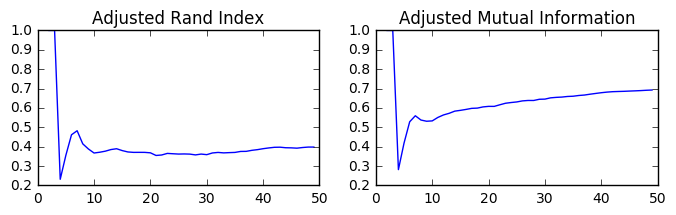

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/BPnd/ward/az.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


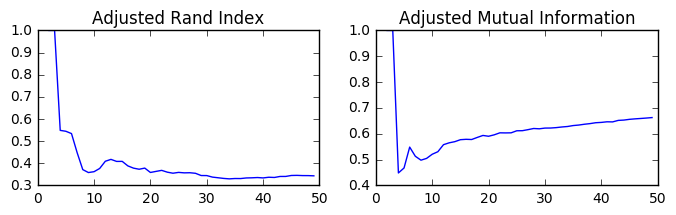

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/BPnd/ward/C36.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


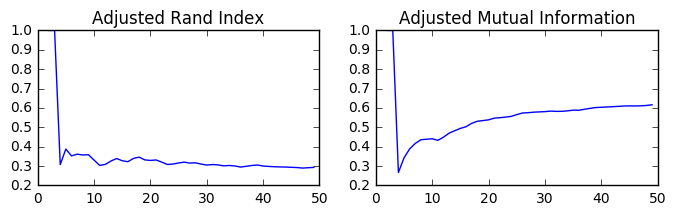

In [10]:
# Cluster BPnd maps using Ward's with spatial constraint
# Dimensionality is estimated based on stability metrics in split-half setting
# This will be useful to see if we gain anything knowledge from decomposing the dynamic data

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
# hemi_type=['lh','rh']
hemi_type=['lh']
targ='fsaverage5'
sm='10'
    
do_whole=True
do_split=True

K_range=np.arange(2,50,1)
N_iter=10

# Perform Ward clustering on BPnd data
for tracer in tracers:                                            
    for hemi in hemi_type:
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        data,_=mu.fs_load_surf_data(fname,mask=fmask)
        data_scaled=scale(data,axis=0)
        
    dest=opj(BPnd_data,'ward')
    mu.assert_dir(dest)
    nstart=0
    nstop=0
    for hemi in hemi_type:
        adjacency,_=mu.fs_load_surf_neighborhood(opj(surf_data,'neigh.'+targ+'.'+hemi+'.matrix'))
        nstop=nstop+adjacency.shape[0]
        hemi_data=data[nstart:nstop,:]
        if do_whole:        
            fname=opj(dest,tracer + '.'+targ+'.'+hemi+'.nii.gz')
            fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
            mu.ward_clustering(hemi_data,adjacency,mode='whole',K_range=K_range,save_out=fname,
                            mask=fmask,verbose=True)
        if do_split:
            mu.ward_clustering(hemi_data,adjacency,mode='split',K_range=K_range,
                               N_iter=N_iter,verbose=True)    

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/ward/cumi.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


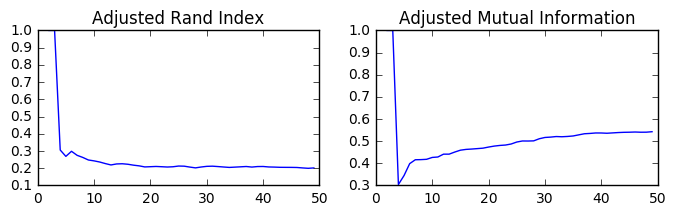

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/ward/dasb.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


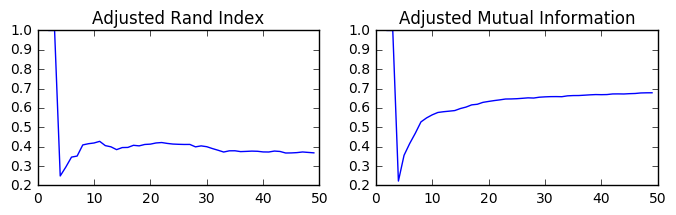

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/ward/sb.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


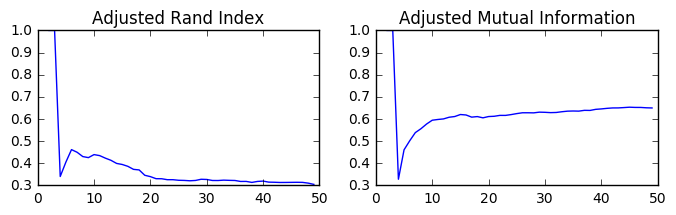

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/ward/az.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


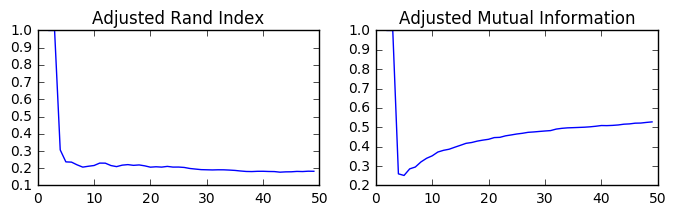

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/ward/C36.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


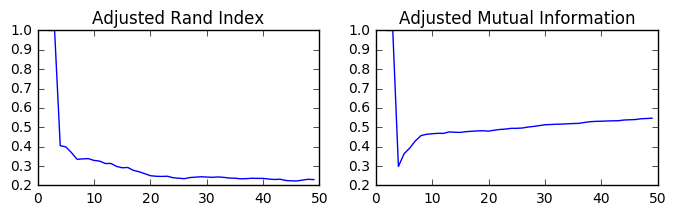

In [4]:
# Cluster MFA components using Ward's with spatial constraint
# Dimensionality is estimated based on stability metrics in split-half setting

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
# hemi_type=['lh','rh']
hemi_type=['lh']
targ='fsaverage5'
sm='10'

K_opt={'cumi': 2, 'dasb': 3,'sb': 2, 'az': 2,'C36': 1}

do_whole=True
do_split=True

K_range=np.arange(2,50,1)
N_iter=10

# Perform Ward clustering on MFA components
for tracer in tracers:
    
    # Load the data
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=preproc['arr_0']
    eig1=preproc['arr_1']
    
    # Divide all datasets by first eigenval
    for ns in np.arange(0,len(data)):
        data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities

    dest=opj(MFA_data,'ward')
    mu.assert_dir(dest)
    nstart=0
    nstop=0
    for hemi in hemi_type:
        adjacency,_=mu.fs_load_surf_neighborhood(opj(surf_data,'neigh.'+targ+'.'+hemi+'.matrix'))
        nstop=nstop+adjacency.shape[0]
        hemi_data=np.ndarray(len(data),dtype='object')
        for ns in np.arange(0,len(data)):
            hemi_data[ns]=data[ns][nstart:nstop,:]
        if do_whole:        
            fname=opj(dest,tracer + '.'+targ+'.'+hemi+'.nii.gz')
            fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
            mu.ward_clustering(hemi_data,adjacency,mode='whole',K_range=K_range,save_out=fname,
                            mask=fmask,svd=True,K_svd=K_opt[tracer],verbose=True)
        if do_split:
            mu.ward_clustering(hemi_data,adjacency,mode='split',K_range=K_range,N_iter=N_iter,
                               svd=True,K_svd=K_opt[tracer],verbose=True)    

In [41]:
# Compute gradient map of MFA weights and BPnd

# modalities={'MFA','BPnd'}
modalities={'MFA'}
targ='fsaverage5'
sm='10'
tracers=['cumi']
hemi_type=['lh']

for hemi in hemi_type:
    for tracer in tracers:
        for modality in modalities:
            
            if modality in 'MFA':
                img=nib.load(opj(MFA_data,'weights',tracer + '.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz'))
                dest=opj(MFA_data,'gradient')
                mu.assert_dir(dest)
            if modality in 'BPnd':
                img=nib.load(opj(BPnd_data,'maps',tracer + '/mean.mrtm2.nopvc.' + 
                             targ + '.' + hemi + '.sm' + sm + '.nii.gz'))
                dest=opj(cluster_data,'BPnd','gradient')
                mu.assert_dir(dest)

            data=img.get_data()
            grad=np.ndarray(data.shape,dtype=data.dtype)
            for nk in np.arange(0,data.shape[3]):
                grad[:,nk]=mu.vlen(mu.build_surface_gradient_matrix(data[0,:,0,nk],opj(targ,hemi +'.pial')),axis=1)

            nib.save(nib.Nifti1Image(grad, np.eye(4)), opj(dest,tracer + hemi + '.' + targ + '.sm' + sm + '.nii.gz'))


ValueError: could not broadcast input array from shape (10242) into shape (1,1,10)

In [22]:
# Compute gradient structure for surfaces

targ_list=['fsaverage5']
hemi=['lh','rh']

for targ in targ_list:
    for hemi in hemi_type:
        fname=opj(subjects_dir,targ,'surf',hemi+'.pial')
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fout=opj(surf_data,'gradstruct.'+targ+'.'+hemi)
        proj,neigh,cortex,border=mu.fs_surf_gradient_struct(fname,fmask,
                            verbose=True,validate_rotation=True,save_out=fout)

Processing C:/Users/vbeliveau/Downloads/fsaverage5\surf\lh.pial
Extracting cortical vertices bordering medial wall
Computing gradient structure for cortical vertices
Saving gradient structure to C:/Users/vbeliveau/Downloads/5HT_clustering_data\surf_data\gradstruct.fsaverage5.lh
Processing C:/Users/vbeliveau/Downloads/fsaverage5\surf\rh.pial
Extracting cortical vertices bordering medial wall
Computing gradient structure for cortical vertices
Saving gradient structure to C:/Users/vbeliveau/Downloads/5HT_clustering_data\surf_data\gradstruct.fsaverage5.rh


In [34]:
# Compute gradient for BPnd and MFA data

process_BPnd=False
process_MFA=True
tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
hemi_type=['lh','rh']
sm='10'
fgrad=opj(surf_data,'gradstruct.'+targ+'.'+hemi)

# Process BPnd
if process_BPnd:
    grad_dest=opj(BPnd_data,'gradient')
    mu.assert_dir(grad_dest)
    for tracer in tracers:
        tracer_dest=opj(grad_dest,tracer)
        mu.assert_dir(tracer_dest)    
        for hemi in hemi_type:
            fi='mean.mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz'
            fname=opj(BPnd_data,'maps',tracer,fi)        
            data=mu.fs_load_surf_data(fname)
            save_out=opj(tracer_dest,'grad.'+fi)
            grad=mu.fs_surf_gradient(data,fgrad,save_out=save_out,verbose=True)

# Process MFA
if process_MFA:
    grad_dest=opj(MFA_data,'gradient')
    mu.assert_dir(grad_dest)
    for tracer in tracers:
        tracer_dest=opj(grad_dest,tracer)
        mu.assert_dir(tracer_dest)    
        for hemi in hemi_type:
            fi='mean.mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz'
            fname=opj(BPnd_data,'maps',tracer,fi)        
            data=mu.fs_load_surf_data(fname)
            save_out=opj(tracer_dest,'grad.'+fi)
            grad=mu.fs_surf_gradient(data,fgrad,save_out=save_out,verbose=True)

Computing gradient
Processing cortical vertices
Processing border vertices
Input dimensions=(10242,), Output dimensions=(1, 10242, 1, 1)
Saving data with dimensions (10242,) to file C:/Users/vbeliveau/Downloads/5HT_clustering_data\BPnd\gradient\cumi\grad.mean.mrtm2.nopvc.fsaverage5.lh.sm10.nii.gz
Computing gradient
Processing cortical vertices
Processing border vertices
Input dimensions=(10242,), Output dimensions=(1, 10242, 1, 1)
Saving data with dimensions (10242,) to file C:/Users/vbeliveau/Downloads/5HT_clustering_data\BPnd\gradient\cumi\grad.mean.mrtm2.nopvc.fsaverage5.rh.sm10.nii.gz
Computing gradient
Processing cortical vertices
Processing border vertices
Input dimensions=(10242,), Output dimensions=(1, 10242, 1, 1)
Saving data with dimensions (10242,) to file C:/Users/vbeliveau/Downloads/5HT_clustering_data\BPnd\gradient\dasb\grad.mean.mrtm2.nopvc.fsaverage5.lh.sm10.nii.gz
Computing gradient
Processing cortical vertices
Processing border vertices
Input dimensions=(10242,), Outp